# Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm

In [1]:
library(tidyverse)
library(bnlearn)
library(Rgraphviz)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:bnlearn’:

    path, score


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

   

_Bayesian Networks_ are graph models whose nodes are random variables, and their edges represent the conditional dependence the variables have on one another. These models can be applied in many fields ranging from Image Processing to Medical Diagnosis. Besides calibrating the conditional probabilities themselves, a critical task in the application is to find the correct Network Structure, i.e. finding the correct directed edges given the nodes.
<div style="text-align:center">
    <img src="https://svgur.com/i/YwF.svg" width="400"/><br>
    <img src="https://www.utf-srl.com/wp/wp-content/uploads/2019/03/down-arrow.png" width="40"/><br>
    <img src="https://svgur.com/i/YxT.svg" width="400"/>
</div>
The task of finding the best network is summarized by the following expression:

$$goal:\quad \max_x\left[P(B_{x}|D)\right]\tag{1}$$

Meaning we aim to find the Bayesian Network $B_x$ that maximizes the probability of the Network being correct, given a set of Data samples D.

Through the definition of conditional probability, we can rearrange the formula (1):

$$P(B_{x}|D)=\frac{P(B_{x},D)}{P(D)}$$

Given $P(D)$ is a constant between models, the task is reduced to finding the model that maximizes $P(B_x,D)$

In accordance with [1], we apply the following formula:
$$P(B_x,D)=P(B_x)\prod_{i=1}^n\prod_{j=1}^{q_i}\frac{(r_i-1)!}{(N_{ij}+r_i - 1)!}\prod_{k=1}^{r_i}N_{ijk}! \tag{2}$$

* $P(B_x)$ is the prior probability of the model, if we assume every model to be as likely as the others then it is just a constant
* $r_i$ is the number of possible value assignments of the i-th variable
* $\pi_i$ is the set of parents for the node i
* $q_i$ the number of unique instantiations of $\pi_i$ relative to D
* $w_{ij}$ denotes the jth unique instantiation of $\pi_i$ relative to D
* $N_{ijk}$ is the number of cases in D in which the variable $x_i$ has the value $v_{ik}$ and $\pi_i$ is instantiated as $w_{ij}$
* $N_{ij}=\sum_{k=1}^{r_i}N_{ijk}$

### Explaination of the equation (2)
Consider the following Bayesian Network:

<img src="https://i.ibb.co/n3hgVxm/RCOv-Zs-QPAZmc-Sym-L.png" width="300"/>

An example of this Network can be:
* **X1**: Road work is on progress
* **X2**: An accident happened
* **X3**: There is traffic on the way to work
* **X4**: I arrive late to work

Let D be the Data about these events,  consider this set:

| X1 | X2 | X3 | X4 |
|----|----|----|----|
| 0  | 0  | 0  | 0  |
| 0  | 0  | 0  | 1  |
| 0  | 1  | 0  | 0  |
| 1  | 1  | 1  | 1  |
| 0  | 1  | 1  | 1  |
| 1  | 0  | 1  | 1  |
<br><br>


The probability of the Bayesian Network to be true given the data is proportional to $P(B_S,D)$ given by the formula (1).

For simplicity, consider the events of each node being only 0 or 1:
$$X1,X2,X3,X4\, \in\,\{0,1\} \qquad\left(=\,\{TRUE,FALSE\}\right)$$

The first term of the $\Pi$ goes through each nodes, let us describe them one by one:
* $n=1$
    * $r_1=2;\hspace{2cm}$  X1 can be either 0 or 1
    * $\pi_1 = \emptyset;\hspace{1.8cm}$ since X1 has no parents
    * $q_1 = 1;\hspace{1.95cm}$ Since $\pi_1=\emptyset$, the possible rearrangments reduce to one
    * $N_{1jk};\hspace{2.4cm}$ If the node has no parents, this ends up being the number of unique terms
    * $N_{1j};\hspace{2.5cm}$ evaluates to the sum of the terms inside the last $\Pi$<br><br>
    
    $$\frac{(2-1)!}{(N_{11}+2 - 1)!}\prod_{k=1}^{2}N_{11k}! = \frac{\prod_{k=1}^{2}N_{11k}!}{(N_{11} +1)!}=$$<br>
    (For k=1 we count the zeros, for k=2 we count the ones)<br>
    $$=\frac{4!2!}{(4+2 +1)!}=0.0095$$

* $n=2$<br>
    Exactly the same, only the terms $N_{ij}$ and $N_{ijk}$ change<br>
    $$\frac{(2-1)!}{(N_{21}+2 - 1)!}\prod_{k=1}^{2}N_{21k}! = \frac{\prod_{k=1}^{2}N_{21k}!}{(N_{21} +1)!}=\frac{3!3!}{(3+3+1)!}=0.0071$$

* $n=3$\
    X3 has parents X1 and X2, this means:
    * $r_3=2;\hspace{2cm}$  X3 can be either 0 or 1
    * $\pi_3 = \{X1,X2\};$
    * $q_3 = 4;\hspace{1.95cm}$ Since both X1 and X2 can assume two values each, the number of all possible permutation of the unique elements of X1 and X2 is 4
    * $w_{3j}=\{ \{0,0\},\{0,1\},\{1,0\},\{1,1\}\}$
    * $N_{3jk};\hspace{2.3cm}$ the number of observations in D that X3 assumes the k-th value, and $\{X1,X2\}$ assume the j-th value from $w_{3j}$<br><br>
    
    $$\prod_{j=1}^{4}\frac{(2-1)!}{(N_{3j}+ 2- 1)!}\prod_{k=1}^{2}N_{3jk}! = \prod_{j=1}^{4}\frac{\prod_{k=1}^{2}N_{3jk}!}{(N_{3j}+ 1)!}$$
     * j = 1\
     We consider when X1 and X2 assume the value $w_{31}=\{0,0\}$
     When \{X1,X2\}=\{0,0\}, X3 is 0 twice (k=1) and is never 1 (k=2)
     
     * j = 2\
     We consider when X1 and X2 assume the value $w_{31}=\{0,1\}$
     When \{X1,X2\}=\{0,1\}, X3 is 0 once (k=1) and once (k=2)
     
     * and so on...
     
     $$\prod_{j=1}^{4}\frac{\prod_{k=1}^{2}N_{3jk}!}{(N_{3j}+ 1)!}=\frac{0!2!}{3!}\frac{1!1!}{3!}\frac{0!1!}{2!}\frac{0!1!}{2!}=0.028$$

* $n=4$\
    For X4 the computation is easier than for X3 because there's only one parent node, meaning that q is only 2:<br><br>
    $$\prod_{j=1}^{2}\frac{(2-1)!}{(N_{4j}+ 2- 1)!}\prod_{k=1}^{2}N_{4jk}!=\prod_{j=1}^{2}\frac{ \prod_{k=1}^{2}N_{4jk}! }{(N_{4j}+ 2- 1)!}=$$<br>
    
    To compute $N_{4jk}$ we must count the times X4 is 0/1 when X3 assumes the values 0 and 1:<br><br>
    
    $$=\frac{2!1!}{4!}\frac{3!0!}{4!}=0.021$$

In [2]:
############ AUXILIARY FUNCTIONS ###############
# Those functions are called when evaluated the probability of a configuration

# When computing the probability of a network we go through each node
# For each node the computation is different depending if they have parents nodes `prob.parents()` or not `prob.noparents()`
prob.noparents <- function(D,namecol,prod)
    {
        # We take the probability computed for the node before and log it
        lprod <- log(prod)
        # Array of instances of the node
        col <- dplyr::pull(D, namecol)
        # Array of unique instances of the node ::ri::
        nunique <- length(unique(col))
        # We add the first term of the formula ::(ri - 1)!::
        lprod <- lprod+lfactorial(nunique-1)
        # Here we compute the first part of the denominator (ri - 1), it still need to Nij
        # to be added and to be factorialized
        den <- nunique - 1
        
        # Last prod serie, here we compute Nijk! (k varies) and we multiply them together
        for(i in 1:nunique)
            {
                lprod <- lprod+lfactorial(length(col[col == unique(col)[i]]))
            
                # We compute Nij by adding Nijk all together
                den <- den + length(col[col == unique(col)[i]])
            }
        # The denominator is complete, now we can subtract it (we would divide it if it wasn't log)
        lprod <- lprod - lfactorial(den)
        
        # Finally we exp the final result to eliminate the log
        nprod <- exp(lprod)
    
        return(nprod)
    }

# This function is called in a apply() in prob.parents()
is.eq <- function(row1,row2){return(row1 == row2)}

prob.parents <- function(BN,D,namecol,prod)
    {
        # We take the probability computed for the node before and log it
        lprod <- log(prod)
        # Array of instances of the node
        col <- dplyr::pull(D, namecol)
        # Array of parents nodes
        parents <- parents(BN, namecol)
        n.parents <- length(parents)
        # Array of values of parents
        col.parents <- D[parents]
        r <- length(unique(col))

        # Here we compute all the possible combinations the selected nodes and
        # its parents nodes may have (of course the value depend on the possible
        # instantiations of each node)
        q <- 1
        combined <- list()
        for(j in 1:length(parents))
            {
                q <- q*length(unique(col.parents[,j]))
                combined[[j]] <- unique(col.parents[,j])    
            }
        combinations <- do.call(expand.grid, combined)
    
        # for j in 1:qi
        for(j in 1:q)
            {
                w  <- combinations[j,]
                # Compute Nijk!
                nij <- 0
                for(k in 1:r)
                    {
                        wij <- c(w,unique(col)[k])
                        nijk <- sum(apply(apply(cbind(col.parents, col),1,is.eq,row2=wij),2,all))
                        nij <- nij + nijk
                        lprod <- lprod+lfactorial(nijk)
                    }
                lprod <- lprod+lfactorial(r - 1) - lfactorial(nij + r - 1)
            }

        nprod <- exp(lprod)
    
        return(nprod)

    }

#############################################

In [3]:
# This is the function for evaluating the probability of a model, it basically go through each node (for i in 1:n)
# and evaluates the probability depending on if the nodes has parents or not
prob.model <- function(BN,D)
    {
        nvar <- length(nodes(BN))
    
        # We instantiate the prior probability of the model to be 1,
        # it's just a constant term since we are supposing each model to be equally probable
        prod <- 1
        for(i in 1:nvar)
            {
                # if the node has no parents
                if(length(parents(BN, nodes(BN)[i])) == 0)
                    {prod <- prob.noparents(D,nodes(BN)[i],prod)}
                else
                    {prod <- prob.parents(BN,D,nodes(BN)[i],prod)}
                
            }
    
        return(prod)
    }

\
```prob.model(BN,D)``` computes the value $P(BN,D)$ through the formula (2), to check if it is correctly implemented, the result is compared with the values shown in [1]:

In [4]:
ex <- read.table("./dataset/cooper.txt", header = TRUE, stringsAsFactors = TRUE)

In the paper the result is:              P(B1,D)=P(B1) 2.23*10^(-9)
through the function implemented we get: P(B1,D)=P(B1) 2.226854e-09 



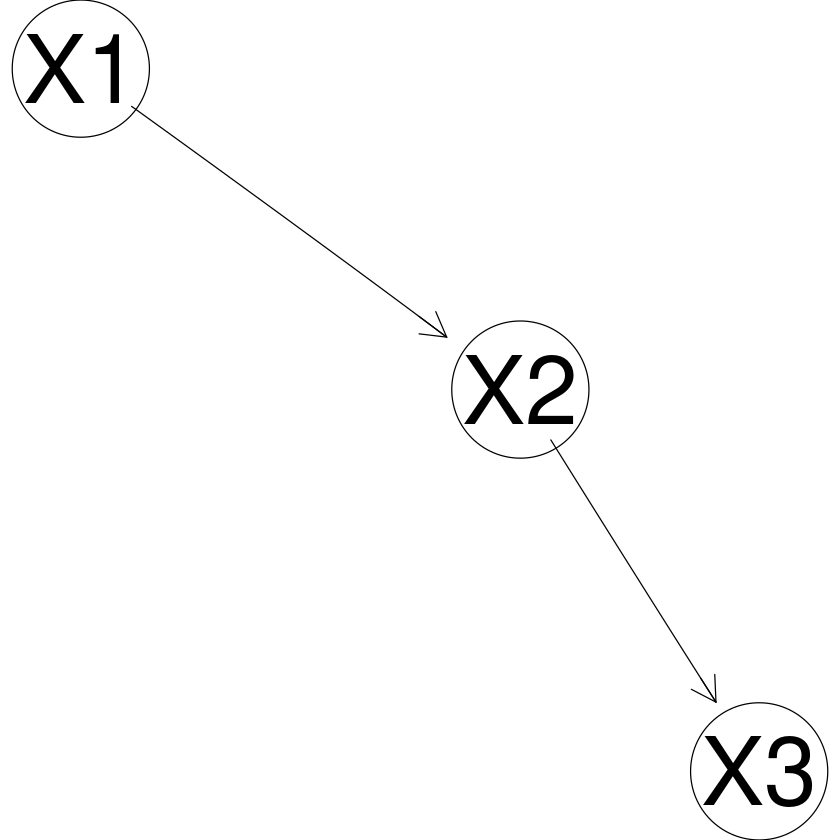

In [5]:
ex.bn1 <- model2network("[X1][X2|X1][X3|X2]")
graphviz.plot(ex.bn1,layout = 'neato')
cat('In the paper the result is:              P(B1,D)=P(B1) 2.23*10^(-9)')
cat('\nthrough the function implemented we get: P(B1,D)=P(B1)',prob.model(ex.bn1,ex),'\n\n')

In the paper the result is:              P(B2,D)=P(B2) 2.23*10^(-10)
through the function implemented we get: P(B2,D)=P(B2) 2.226854e-10 


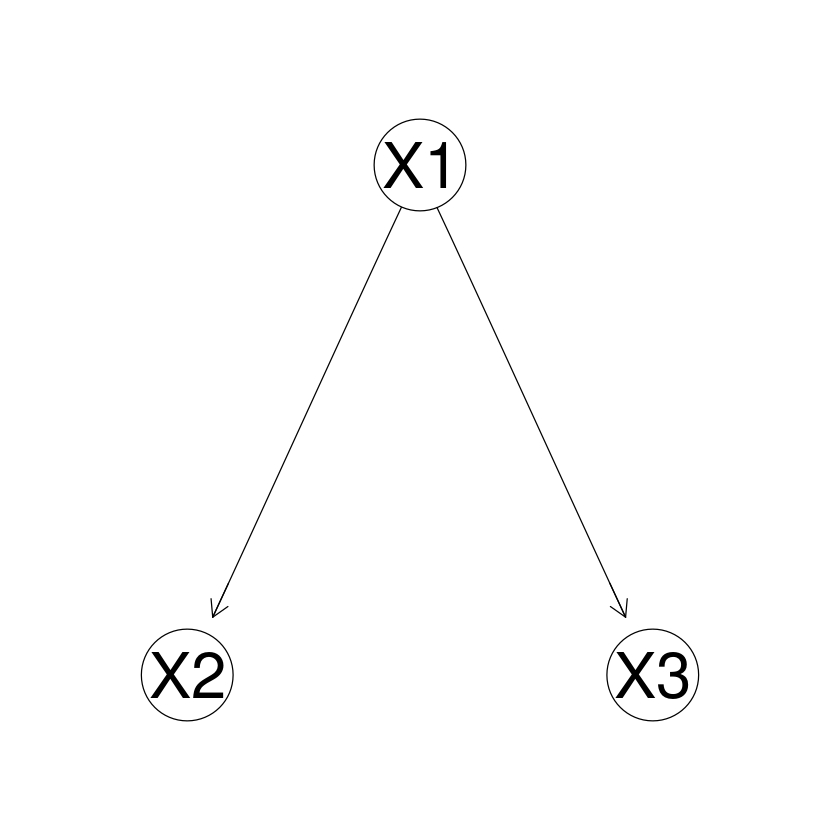

In [6]:
ex.bn2 <- model2network("[X1][X2|X1][X3|X1]")
graphviz.plot(ex.bn2)
cat('In the paper the result is:              P(B2,D)=P(B2) 2.23*10^(-10)')
cat('\nthrough the function implemented we get: P(B2,D)=P(B2)',prob.model(ex.bn2,ex),'\n')

The function ```prob.model(BN,D)``` seems to work well since it reproduces the same values of the paper!

\
Now that we have a way to compute the probability of a model to be true, we could theoretically compute it for every model and choose the one with the highest value. However according to Robinson's formula:

$$ f(n)=\sum_{i=1}^n (-1)^{i+1}\left(\array{n \\ i}\right)2^{i(n-i)}f(n-i) \tag{3}$$

the number of possible Networks grows exponentially as the number of nodes increases:

In [7]:
# Robinson recursive formula to compute the number of possible belief-network stuctures
# that contains n nodes
# FORMULA (3)
n.networks.structure <- function(n)
    {
        # End of recursive function
        if(n <= 1){return(1)}
        
        else
            {
                i <- 1
                res <- 0
                while(i <= n)
                    {
                        res <- res + ((i%%2)*2 - 1)*(choose(n,i)*(2^(i*(n-i)))*n.networks.structure(n-i))
                        i <- i + 1
                    }

                return(res)
            }
    }

# Computing the number of possible configurations for networks with 2,3...,8 nodes
for(i in 2:8)
    {
        cat('For',i,'nodes the number of possible structures is: ',n.networks.structure(i),'\n')
    }


For 2 nodes the number of possible structures is:  3 
For 3 nodes the number of possible structures is:  25 
For 4 nodes the number of possible structures is:  543 
For 5 nodes the number of possible structures is:  29281 
For 6 nodes the number of possible structures is:  3781503 
For 7 nodes the number of possible structures is:  1138779265 
For 8 nodes the number of possible structures is:  783702329343 


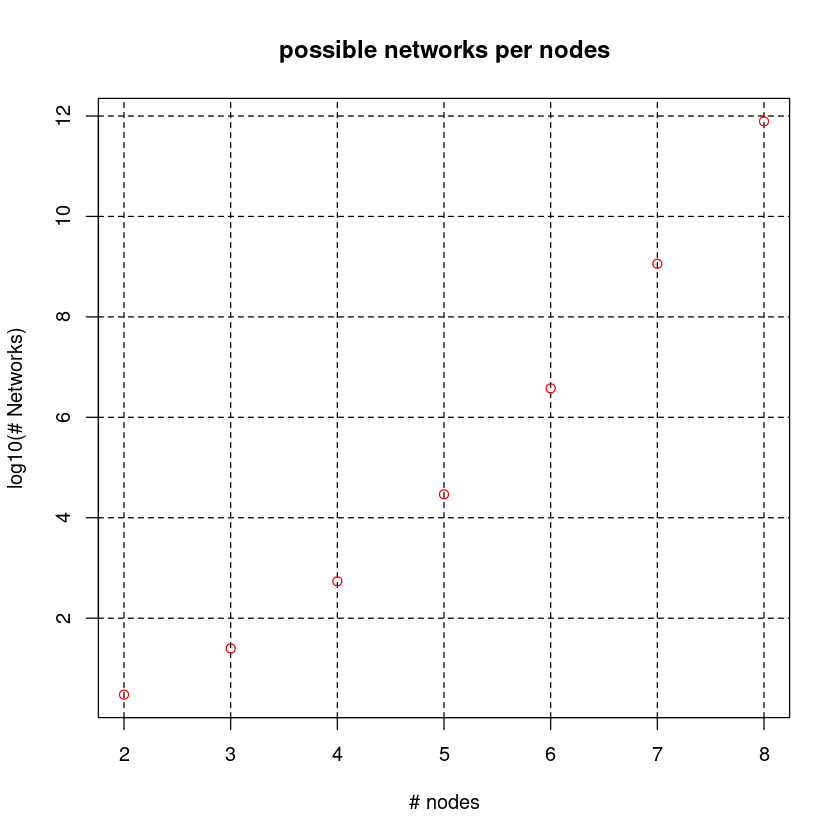

In [8]:
plot(2:8,log10(sapply(2:8,n.networks.structure)), main = 'possible networks per nodes', xlab = '# nodes', ylab = 'log10(# Networks)', panel.first = grid(col = 'black', lwd = 1,lty = 2), col = 'red')

\
Even for small Networks, it would be preferable to apply a more heuristic approach in finding the best Network. The approach chosen here is the K2 algorithm [2]


## 1. Implement the algorithm K2 in R and check its performances with the test data set given in [2]

### Implementing K2 algorithm

The K2 algorithm is a heuristical method for searching the most porbable belief-network structure given a database of cases.\
It assumes that there exist a hierarchy of nodes, in which the first has no parents, and the others can only be child of the
previous ones.
The algorithm also needs to have specified the number of parents that each node may have.\

K2 algorithm cycles through each nodes and it seaches for the most probable configuration in the following manner:
* Compute the probability of the model in which the node has no parents
* Consider the configuration with the highest probability where a node (hierarchically higher) is linked to the current node
* If the probability of the new configuration is lower or the same, it stops and the current node has no parent, else we now consider the two nodes linked.
* Consider the configuration with another node linked to the current one, if it exists repeat

In [9]:
# This is the function f of the paper Illustration of the K2 Algorithm for learning Bayes Net Structures
# it is a similar function of prob.model
f <- function(BN,D,i)
            {
                prod <- 1
            
                if(length(parents(BN, nodes(BN)[i])) == 0)
                    {prod <- prob.noparents(D,nodes(BN)[i],prod)}
                else
                    {prod <- prob.parents(BN,D,nodes(BN)[i],prod)}
               
                return(prod)
            }

In [10]:
K2 <- function(N,D,u)
    {
        # We first consider the configuration where each node is independent
        BN <- empty.graph(nodes = N)
    
        # We skip the first node since we suppose it can't have parents
        for(i in 2:length(N))
            {
                # We save in p.old the probability of the model in the current configuration
                p.old <- f(BN,D,i)
                ok.to.proceed <- TRUE
                j <- i - 1
                                
                while(ok.to.proceed & (length(parents(BN,nodes(BN)[i])) < u) )
                    {   
                        j <- i - 1
                        proposal <- c()
                    
                        while(j > 0)
                            {
                                    # We propose the configuration where the jth node is linked to the current one
                                    BN.proposal <- set.arc(BN, from=nodes(BN)[j], to=nodes(BN)[i])
                                    # And we compute the probability
                                    proposal <- c(proposal, f(BN.proposal,D,i))

                                    j <- j - 1 
                            }
                        
                        # We take the model with the highest probability
                        p.new <- max(proposal)
                        best.BN   <- set.arc(BN, from=nodes(BN)[i - match(max(proposal),proposal)], to=nodes(BN)[i])
                        # Does the new configuration beat the current one?
                        if(p.new > p.old)
                            {
                                    p.old <- p.new
                                    BN <- best.BN
                            }
                        # If not then we need to exit
                        else{ok.to.proceed <- FALSE}
                    }
                
            }
        
        return(BN)
    }

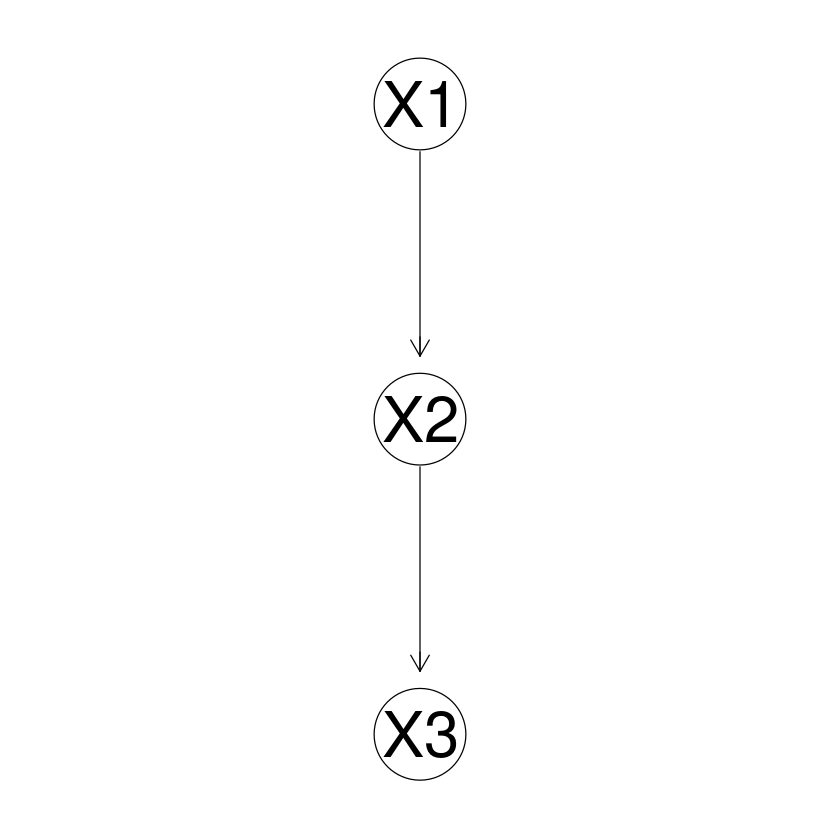

In [11]:
graphviz.plot(K2(c('X1','X2','X3'),ex,3))

## 2. Implement and test the K2 algorithm with the test data sets ([2]).  Investigate if it is possible to code it inside the bnstruct R package

In [12]:
suppressMessages(library(bnstruct)) # we load bnstruct but suppress the messages, too pedantic!

### Testing bnstruct on ([2]) dataset

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



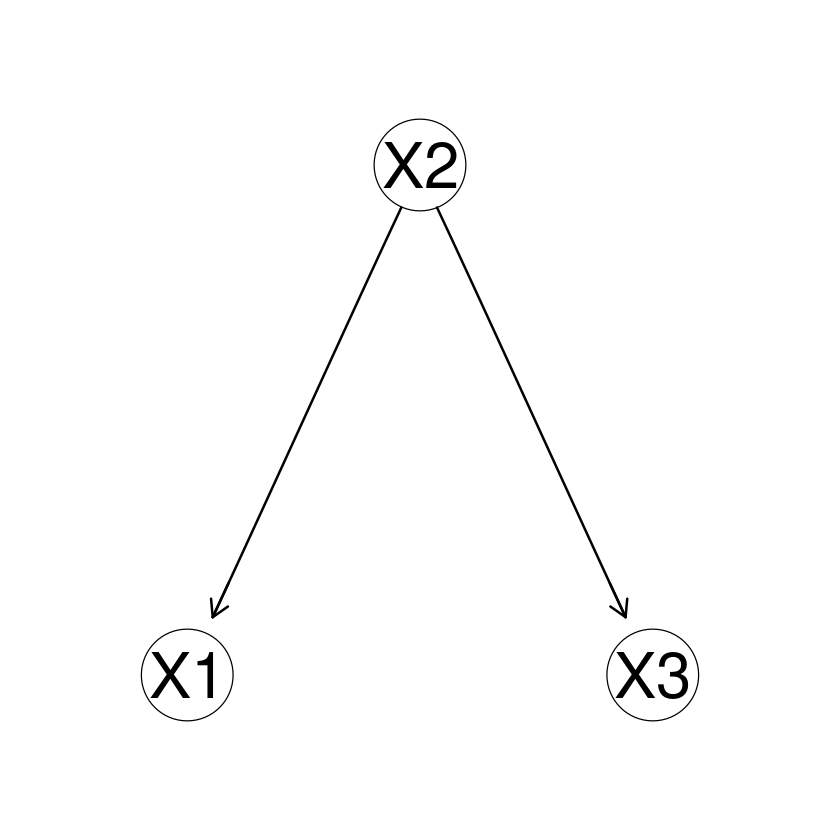

In [13]:
ex.cooper <- read.table("./dataset/cooper.txt", header = TRUE, stringsAsFactors = TRUE)

# ex.cooper variables assume the values {0,1}, however in bnstruct, 0 is considered out of range, we need to shift every
# value to 1 ({0,1} -> {1,2})
ex.cooper <- ex.cooper + 1

dataset.cooper <- BNDataset(data = ex.cooper,                                 # dataset
                            num.nodes = 3,                                    # number of nodes
                            variables = c('X1','X2','X3'),                    # names of the variables
                            discreteness = matrix(c(TRUE,TRUE,TRUE),nrow=1),  # TRUE if the variable is discreet
                            node.sizes = c(2,2,2))                            # cardinality of the variables

bn.cooper <- learn.network(dataset.cooper)

plot(bn.cooper)

The structure learnt by bnstruct seems correct, however the arrow: $X1\leftarrow X2$ is directed wrongly. This could be caused either by the heuristic search of the model, or by the plot function

The default learning method is MMHC. From the options avaible there is no K2 method:

In [14]:
bn.cooper <- learn.network(dataset.cooper,
                           algo='k2')  # algo is the algorithm to find the best model, default = MMHC

bnstruct :: structure learning algorithm not recognized, using MMHC

bnstruct :: (available options are: SM, MMHC, MMPC, HC, SEM)

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



We now unload the package bnstruct to load a local modified version of it:

In [15]:
detach(package:bnstruct, TRUE)

In [16]:
library(devtools)
suppressMessages(load_all('./bnstruct-modified'))

Loading required package: usethis



Error in get(genname, envir = envir) : object 'testthat_print' not found


The local _bnstruct_ package was modified in order to host another algorithm method for k2. If K2 is passed as an input of the parameter ```algo``` in the function ```learn.network()```, the function K2 seen above will be used

bnstruct :: USING CUSTOM METHOD: K2

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



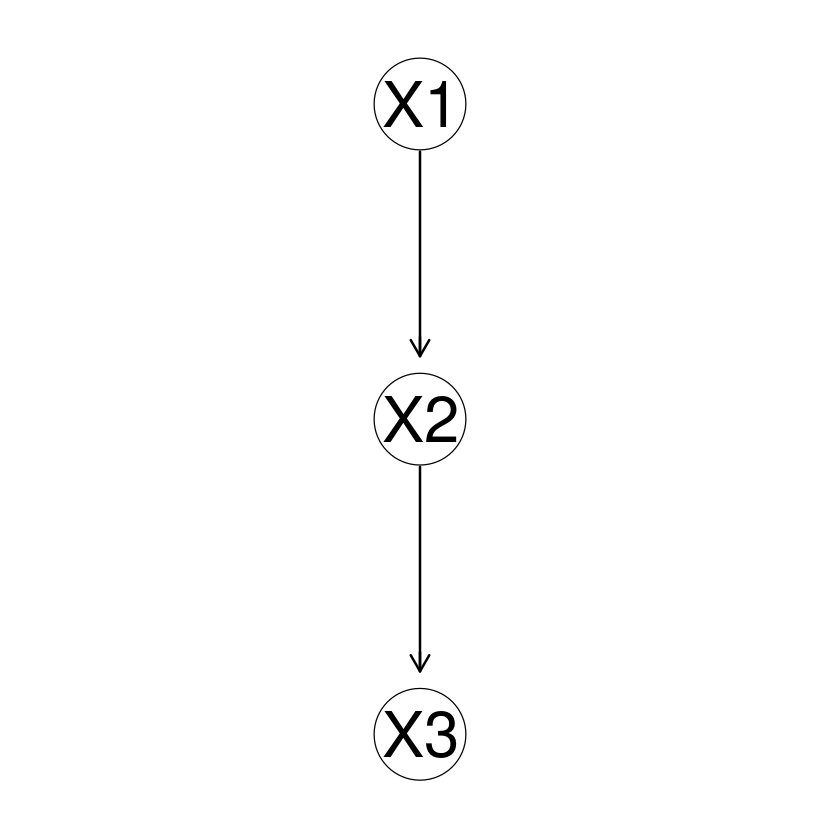

In [17]:
D <- read.table("./dataset/cooper.txt", header = TRUE, stringsAsFactors = TRUE)
bn.cooper <- learn.network(dataset.cooper, algo='k2', max.parents = 3)
plot(bn.cooper)

### Testing bnstruct on SURVEY dataset

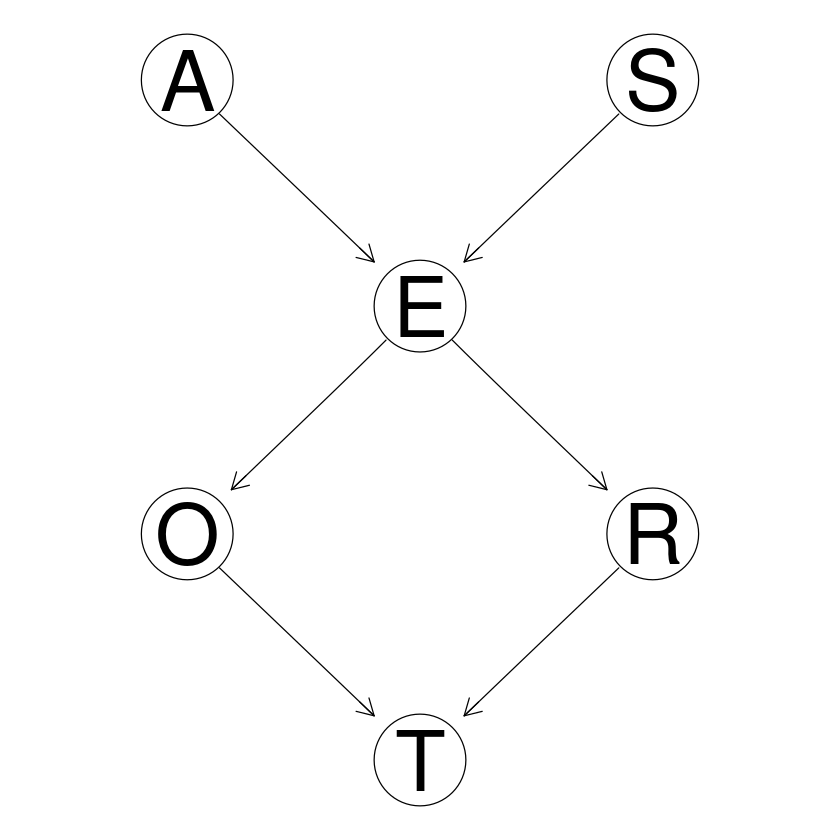

In [18]:
# From the theory lessons: We build the most 'correct' dataset, i.e the ones that outputs the highest probability:
survey.bn.best <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))
survey.bn.best <- set.arc(survey.bn.best, from = "A", to = "E")
survey.bn.best <- set.arc(survey.bn.best, from = "S", to = "E")
survey.bn.best <- set.arc(survey.bn.best, from = "E", to = "O")
survey.bn.best <- set.arc(survey.bn.best, from = "E", to = "R")
survey.bn.best <- set.arc(survey.bn.best, from = "O", to = "T")
survey.bn.best <- set.arc(survey.bn.best, from = "R", to = "T")
graphviz.plot(survey.bn.best)

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



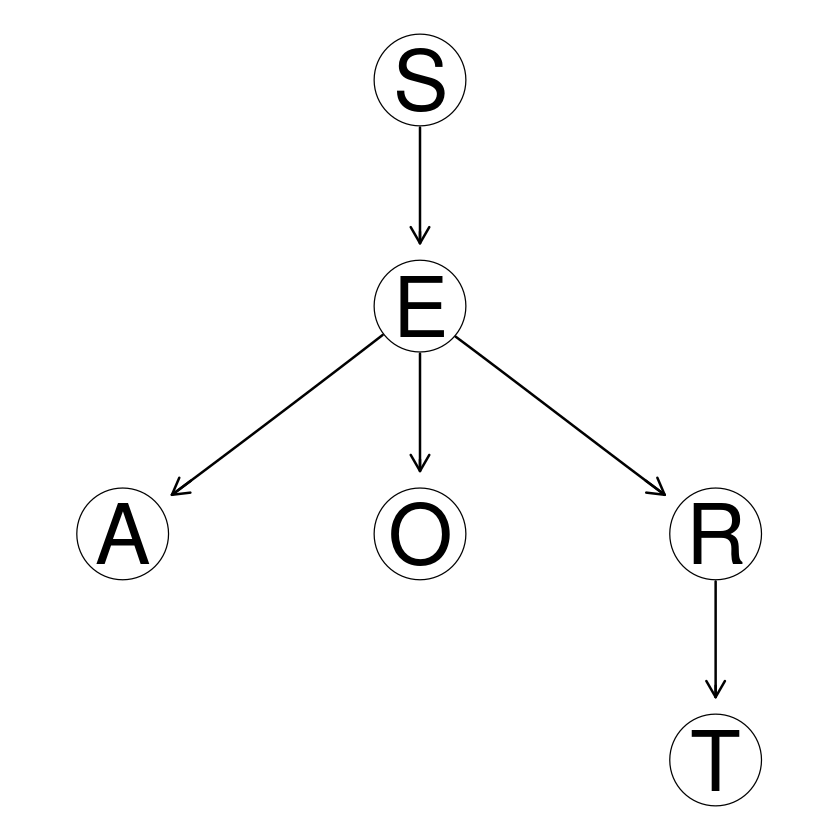

In [19]:
# Loading the survey dataset
ex.survey <- read.table("./dataset/surveymod.txt", header = TRUE, stringsAsFactors = TRUE)

# Adding 1 to each values, having 0 as a possible value the nodes could assume caused errors
ex.survey.mod <- ex.survey + 1

# Set the hierarchy
ex.survey.mod <- ex.survey.mod[c('A','S','E','O','R','T')] 

dataset.survey <- BNDataset(data = ex.survey.mod,                                             # dataset
                            variables = names(ex.survey.mod),                                 # names of the nodes
                            num.nodes = 6,                                                    # number of nodes
                            discreteness = matrix(c(TRUE,TRUE,TRUE,TRUE,TRUE,TRUE),nrow=1),   # TRUE if nodes i is discreet
                            node.sizes = c(3,2,2,2,2,3))                                      # cardinality of the nodes

# learn.network will use an heuristic approach (not K2) to learn the structure. Default = MMHC
bn.survey <- learn.network(dataset.survey)

plot(bn.survey)

The two networks are obviously different, this is because the heuristic approach MMHC did not find the best model.

bnstruct :: USING CUSTOM METHOD: K2

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



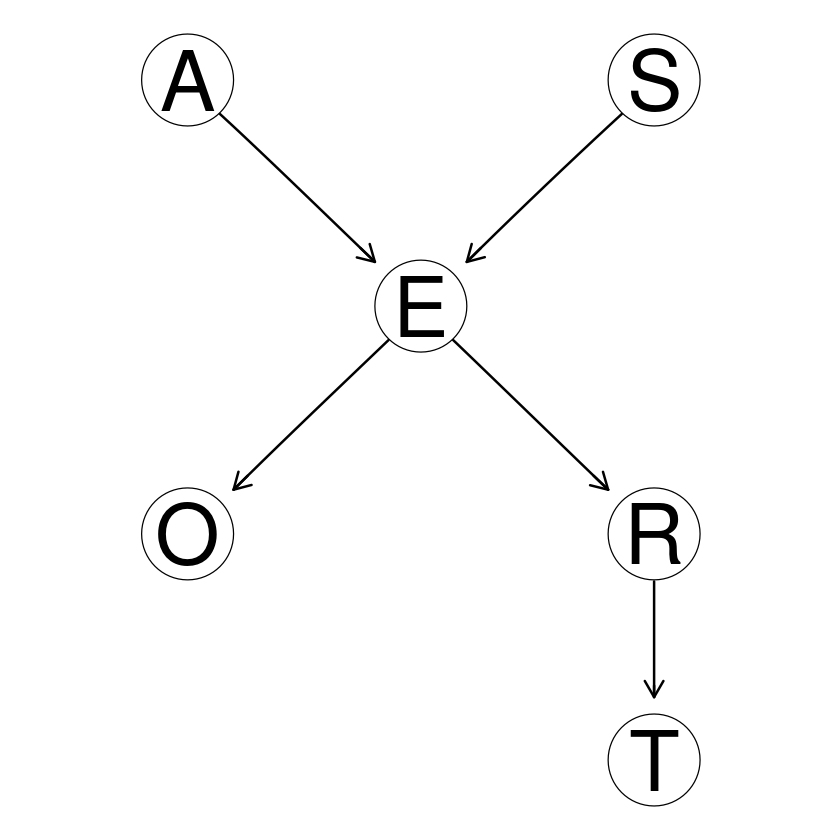

In [20]:
bn.survey <- learn.network(dataset.survey, algo='k2', max.parents = 3)
plot(bn.survey)

## Further improvements
For the task of finding the best Network, Factorials play a central role (See Equation 2).\
The larger the dataset is, the bigger the arguments in the factorials become. This considerably limits the size of datasets that could be used with a direct implementation.

Another obstacle happens when dealing with datasets with a high number of nodes, in fact the probabilities computed by the function ```prob-model()``` are so low (given the high number of possible networks) that they are all approximated as 0, making the task of finding the one with the highest probability, not possible.

This means that in order to apply this algorithm with High Numbers of Nodes and Instances, one must deal with high numbers (due to the factorials) and small numbers (due to the small probabilities) that would normally Overflow and Underflow, respectively.

This restriction was surpassed in part by means of the built-in log-factorial function (```lfactorial()```) along with other logarithmic techniques within the calculation of probabilities.

The code could also be improved by implementing advanced factorial functions (e. g. ```gmp::factorialZ()```) or using workarounds such as _Strirling approximation_.

## References
[1] G. F. Cooper and E. Herskovits, _A Bayesian Method for the Induction of Probabilistic Networks from Data_, Machine Learning 9, (1992) 309\
[2] C. Ruiz, _Illustration of the K2 Algorithm for learning Bayes Net Structures_, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf \
[3] A. Franzin et al., _bnstruct: an R package for Bayesian Network structure learning in the presence of missing data_, Bioinformatics 33(8) 2017 1250\
[4] F. Sambo and A. Franzin, _bnstruct: an R package for Bayesian Network structure learning in the presence of missing data_, December 12, 2016